In [186]:
# To make plot backgrounds white
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import sympy as sym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [199]:
# Functions to get matrices
def M_quad( K, fact = -70.33, L = 1., show = False ):
    '''
    Returns the linear map of a quadrupole
    K : (float) the dipole gradient [T/m]
    fact : (float) factor to multiply K with in order to get the focussing length
    L : (float) Length of the quad. Not necessary for thin lens approximation    
    '''
    M = np.diag( np.ones(4) ) + np.diag([ -K * fact, 0, K * fact ], k = -1)
    return M

def M_drift( L = 1., gamma0 = 1.1, show = False ):
    '''
    Returns the linear map of a drift
    L : (float) Length of the drift.
    gamma0 : (float) gamma of reference particle [ ]
    show : (boolean)
    '''
    if show:
        print('Drift of length ', L)
    P0 = np.sqrt( np.power(gamma0,2.) - 1 )
    return np.diag(np.ones(4)) + np.diag( [ L / P0, 0, L / P0 ], k = 1 )


    Next drift Type     On  Max gradient  Length   Skew      Pos
0       0.2470   Rs      0           9.0    0.10   True  12.4602
1       0.3830   Rs      0           9.0    0.10   True  12.7072
2       0.7075   Rs      0           9.0    0.10   True  13.0902
3       0.2650  IMP   True          15.0    0.12  False  13.7977
4       0.2515  IMP      0          15.0    0.12  False  14.0627
5       0.2700  IMP   True          15.0    0.12  False  14.3142
6       2.3370  IMP      0          15.0    0.12  False  14.5842
7       0.3480    P      0           3.0    0.10  False  16.9212
8       0.3090    P      0           3.0    0.10  False  17.2692
9       6.1865    P      0           3.0    0.10  False  17.5782
10      0.2520  IMP  False          15.0    0.12  False  23.7647
11      0.2580  IMP  False          15.0    0.12  False  24.0167
12      1.9980  IMP  False          15.0    0.12  False  24.2747


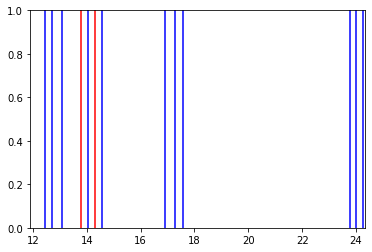

In [254]:
# Quad parameters in a dataframe
# All units in meters
L6 = 10.36
first_quad_pos = L6 + ( 121.07 + 88.95 ) * 1e-2
# Here give quad types and parameters
# Syntax: [L_drift that follows quad, type, on or off [0,1]]
quads = [[.247, 'Rs', 0], [.383, 'Rs', 0], [.7075, 'Rs', 0],
         [.265, 'IMP', True], [.2515, 'IMP', 0], [.27, 'IMP', True], [2*.547 + 1.02 + .223 , 'IMP', 0],
         [.348, 'P', 0], [.309, 'P', 0], [.4005 + 1.285 + .7 + .724 + .83 + .39 + 1.083 + .774, 'P', 0],
         [.252, 'IMP', False], [.258, 'IMP', False], [.994 + 1.004, 'IMP', False]]
# Syntax 'name' : [ max_grad, length, skew_boolean [0,1] ]
quad_dict = {'Rs' : [9,.1,1], 'R' : [9,.1,0], 'P' : [3,.1,0], 'IMP' : [15,.12,0]}
quads = pd.DataFrame( quads, columns = ['Next drift', 'Type', 'On'])
quads['Max gradient'] = np.nan
quads['Length'] = np.nan
quads['Skew'] = np.nan
quads['Pos'] = np.nan
pos = first_quad_pos
fig,ax = plt.subplots()
for i, r in quads.iterrows():
    info = quad_dict[r['Type']]
    quads.loc[i,'Max gradient'] = info[0]
    quads.loc[i,'Length'] = info[1]
    quads.loc[i,'Skew'] = bool(info[2])
    quads.loc[i,'Pos'] = pos
    if r['On']:
        c = 'r'
    else:
        c = 'b'
    ax.axvline(pos, color = c)
    pos += r['Next drift']
print(quads)
plt.show()

In [256]:
# Set beam parameters
E = 50  # MeV
mc2 = .511
gamma0 = E / mc2
P0 = np.sqrt( np.power(gamma0,2.) - 1 )
print('Reference particle has gamma = ', gamma0, '\n and momentum P0 = ', P0 )

# Fake beam moments matrix
rmsx = 2.25e-3
rmspx = 25e-3
xpx = -.9

x2 = np.power(rmsx,2.)  # Beam size
p2 = np.power(rmspx,2.)  # Normalised momentum spread
xpx *= rmsx * rmspx
sig = np.array([
    [x2, xpx],
    [xpx, p2] ])
Z = np.zeros([2,2])
sig = np.block([
    [sig, Z],
    [Z, sig] ])
print(sig)

Reference particle has gamma =  97.84735812133073 
 and momentum P0 =  97.84224798789093
[[ 5.0625e-06 -5.0625e-05  0.0000e+00  0.0000e+00]
 [-5.0625e-05  6.2500e-04  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  5.0625e-06 -5.0625e-05]
 [ 0.0000e+00  0.0000e+00 -5.0625e-05  6.2500e-04]]


In [257]:
# Make matrices
numQ = int( np.sum(quads['On']) )  # Number of quads
Ks = sym.symbols('K0:%d'%numQ, real = True)  # Quadrupole strengths
Klims = np.zeros(numQ)
print(Ks)
Ms = []
prevpos = first_quad_pos
qi = 0
for i, r in quads.iterrows():
    if r['On']:
        Ms.append( M_drift( L = r['Pos'] - prevpos, gamma0 = gamma0, show = True ) )
        Ms.append( M_quad( K = Ks[qi] ) )
        Klims[qi] = r['Max gradient']
        prevpos = r['Pos']
        qi += 1
    if i == quads.shape[0]-1:
        Ms.append( M_drift( L = r['Pos'] + r['Next drift'] - prevpos, gamma0 = gamma0, show = True ) )

# Invert order of matrices since they should go right-to-left
Ms.reverse()
Mtot = np.linalg.multi_dot(Ms)
# for M in Ms:
#     print(M, '\n\n')
#print(Mtot)
#print(np.linalg.det(Mtot))        

(K0, K1)
Drift of length  1.3374999999999986
Drift of length  0.5165000000000006
Drift of length  11.958499999999997


In [258]:
# Solve for rmsxFinal = rmsyFinal
sigFinal = np.linalg.multi_dot( [Mtot, sig, Mtot.T] )
soleq = sym.solve( sigFinal[0,0] - sigFinal[2,2], Ks, dict = True)
print('Hello there')

Hello there


In [262]:
nsols = len(soleq)
nfp = numQ - len(soleq[0])
print('nsols = ', nsols, ', n free params = ', nfp)
s = soleq[0][Ks[0]]
factor = .1
diff = factor * sig[0,0] - sigFinal[0,0].subs(Ks[0],s)

nsols =  2 , n free params =  1


In [272]:
poss = np.linspace(-15,15,100)
m = 1
mposs = -15
for p in poss:
    nowdiff =  diff.subs(Ks[1],p)
    if np.abs( nowdiff ) < m:
        m = nowdiff
        mposs = p
print( 'min diff = ', m, ', for K1 = ', mposs, ', and K0 = ', s.subs(Ks[1], mposs) )
# sols = sym.solve( diff, Ks[1], dict = True )
print( "Hello there general Kenobi, I have found the solution young Skywalker, for factor ", factor)
#print(sols)


min diff =  -0.952058419231182 , for K1 =  -13.181818181818182 , and K0 =  11.8957252713044
Hello there general Kenobi, I have found the solution young Skywalker, for factor  0.1


In [239]:
nsols = len(sols)
nfp = numQ - len(sols[0])
print('There are ', nsols, ' solutions, with ', nfp, ' free parameters.')
#print( '\n', sols[0] )
s = sols[0][Ks[0]].subs(Ks[1],-.5).subs(Ks[2],-.5).subs(Ks[3],-.5)
print( '\n', 's = ', s)
eq = sig[0,0] - sigFinal[0,0].subs(Ks[0],s)


There are  2  solutions, with  3  free parameters.

 s =  1.29419647160537


In [240]:
sols2 = sym.solve( eq, Ks[1:], dict = True )

In [244]:
nsols = len(sols)
print('There are ', nsols, ' solutions' ) 
print(sols2)

There are  2  solutions
[{K1: (-9.86474876862286e+85*K2**2*K3**2 - 1.04005424855854e+87*K2**2*K3 - 2.74135932225996e+87*K2**2 - 1.64115776078761e+87*K2*K3**2 - 1.20650206012366e+88*K2*K3 - 1.79947293380955e+88*K2 - 6.27367880030257e+87*K3**2 - 2.25735848688921e+88*K3 + 1.19792506854876e+87*sqrt(-6.24554923350268e-7*K2**4*K3**4 - 1.31695396755508e-5*K2**4*K3**3 - 0.000104136222921486*K2**4*K3**2 - 0.000365974250396278*K2**4*K3 - 0.000482314708305558*K2**4 - 2.66912548326836e-5*K2**3*K3**4 - 0.00049649464891683*K2**3*K3**3 - 0.00340150712206407*K2**3*K3**2 - 0.0101110639341923*K2**3*K3 - 0.0108962552684147*K2**3 - 0.000427758467214727*K2**2*K3**4 - 0.00689397622445018*K2**2*K3**3 - 0.0386627199820031*K2**2*K3**2 - 0.083543291967253*K2**2*K3 - 0.045576960368356*K2**2 - 0.00304681243885396*K2*K3**4 - 0.041533033262222*K2*K3**3 - 0.169320671063318*K2*K3**2 - 0.150538240822824*K2*K3 + 0.180325690878183*K2 - 0.00813812006282448*K3**4 - 0.0907136118259318*K3**3 - 0.187215650429088*K3**2 + 0.36

In [136]:
# Compute factor for K
rmsx = 2.24e-3
rmspx = 25e-3
xpx = -.865
rmspxf = 155e-3
K = 1.118

a = np.power( K*rmsx, 2. )
b = -2 * ( xpx * rmsx * rmspx ) * K
c = np.power( rmspx, 2. ) - np.power( rmspxf, 2. )

Delta = np.sqrt( b**2 - 4 * a * c )
s1 = ( -b + Delta ) / (2*a)
s2 = ( -b - Delta ) / (2*a)
print(s1)
print(s2)


53.05494313423192
-70.32510030264491
